# 2. FERPlusCNN02+SVM+XGBoost 분류

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
import tensorflow as tf
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

import keras.backend.tensorflow_backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Add, Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.optimizers import Adam, Adadelta
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## 2.1. 학습에 사용될 하이퍼 패러미터 선언 및 Random Seed 설정

In [2]:
np.random.seed(201)

In [3]:
FER2013_DIR = "datasets/ferPlus/prep/"
INPUT_TRAIN_DATA = 'ferPlus_X.npy'
LABEL_TRAIN_DATA = 'ferPlus_y.npy'

TEST_SPLIT = 0.2
RND_SEED = 0

In [4]:
input_data = np.load(open(FER2013_DIR + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(FER2013_DIR + LABEL_TRAIN_DATA, 'rb'))

In [5]:
input_shape = input_data[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (48, 48, 1)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(input_data,
                                                    label_data,
                                                    test_size=TEST_SPLIT,
                                                    random_state=RND_SEED)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=TEST_SPLIT,
                                                  random_state=RND_SEED)

In [14]:
x_train.shape

(8784, 48, 48, 1)

In [15]:
x_val.shape

(2196, 48, 48, 1)

In [16]:
x_test.shape

(2746, 48, 48, 1)

## 2.2 CNN모델 정의

모델 컴파일

In [8]:
def cnn_module(image, nFilter=256):
    conv1_1 = Conv2D(nFilter, kernel_size=1, activation='relu', kernel_initializer='he_normal', padding='same')(image)
    
    conv2_1 = Conv2D(nFilter, kernel_size=1, activation='relu', kernel_initializer='he_normal', padding='same')(image)
    conv2_2 = Conv2D(nFilter, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(conv2_1)
    
    conv3_1 = Conv2D(nFilter, kernel_size=1, activation='relu', kernel_initializer='he_normal', padding='same')(image)
    conv3_2 = Conv2D(nFilter, kernel_size=(1, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3_1)
    conv3_3 = Conv2D(nFilter, kernel_size=(3, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv3_2)
    
    x = Add()([conv1_1, conv2_2, conv3_3, image])
    
    x = Conv2D(nFilter, kernel_size=1, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    return x

In [9]:
image_input=Input(shape=input_shape)

x = Conv2D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(image_input)
x = Conv2D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Conv2D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(x)

x = AveragePooling2D(pool_size=(3, 3))(x)

x = Conv2D(256, kernel_size=1, activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Conv2D(256, kernel_size=(1, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Conv2D(256, kernel_size=(3, 1), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(3, 3))(x)
x = Dropout(0.3)(x)
    
x = cnn_module(x)
x = cnn_module(x)
x = cnn_module(x)
x = cnn_module(x)
x = cnn_module(x)
x = cnn_module(x)

#x = AveragePooling2D(pool_size=(3, 3))(x)
x = MaxPooling2D(pool_size=(3, 3))(x)
#x = GlobalMaxPooling2D()(x)

#Flatten and output
x = Flatten(name = 'flatten')(x)
x = Dense(1000)(x)
x = Dropout(0.2)(x)

out = Dense(2, activation='softmax', name = 'output')(x)

In [10]:
model=Model(image_input, out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 128)  1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 48, 48, 128)  147584      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 48, 48, 128)  147584      conv2d_2[0][0]                   
____________________________________________________________________________________________

모델 플롯 생성

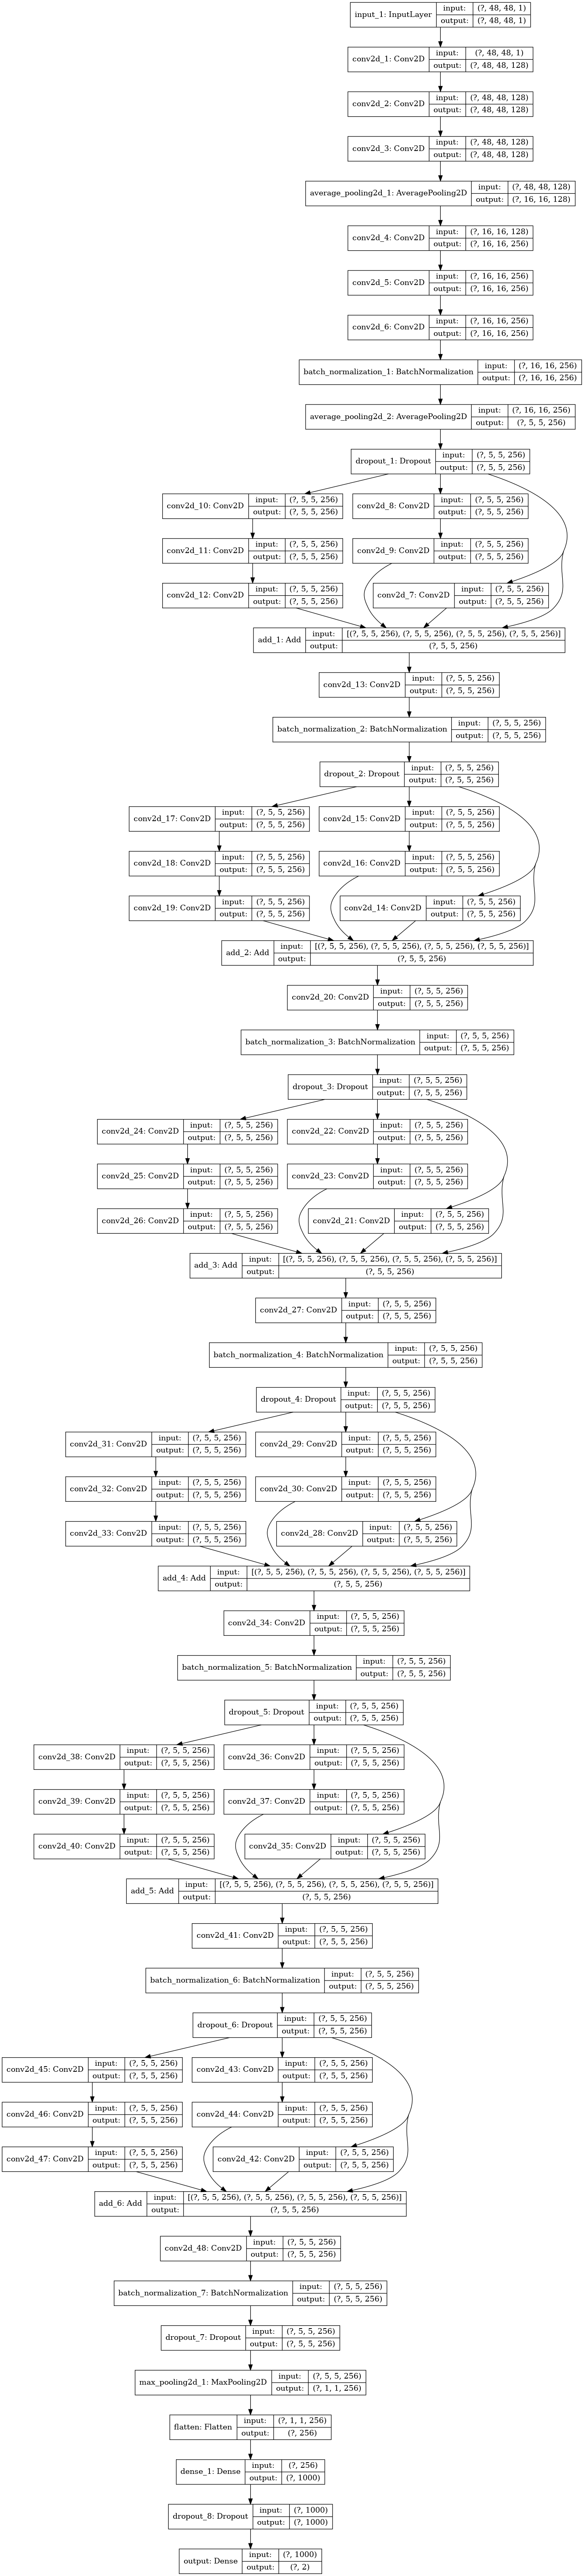

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='cnn/plot_new/ferPlus/model.png')

In [12]:
model.compile(optimizer = Adam(lr=.00025) , loss = 'binary_crossentropy', metrics=['accuracy'])

In [13]:
MODEL_PATH = 'cnn/weight_new/ferPlus/model_weights.h5f'

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
check_point = ModelCheckpoint(filepath=MODEL_PATH, monitor='val_accuracy', verbose=1, save_best_only=True)

## 2.3 CNN 모델 훈련

In [15]:
batch_size = 32
epochs = 100

In [16]:
# Training
with K.tf_ops.device('/device:GPU:0'):
    history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size,
                        validation_data = (x_val, y_val), callbacks=[learning_rate_reduction, check_point])

Train on 8784 samples, validate on 2196 samples
Epoch 1/100
8784/8784 [==============================] - 14s 2ms/step - loss: 0.9386 - accuracy: 0.5962 - val_loss: 0.6911 - val_accuracy: 0.5278

Epoch 00001: val_accuracy improved from -inf to 0.52778, saving model to cnn/weight_new/ferPlus/model_weights.h5f
Epoch 2/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.7072 - accuracy: 0.6587 - val_loss: 0.6140 - val_accuracy: 0.6972

Epoch 00002: val_accuracy improved from 0.52778 to 0.69718, saving model to cnn/weight_new/ferPlus/model_weights.h5f
Epoch 3/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.6444 - accuracy: 0.6705 - val_loss: 0.6105 - val_accuracy: 0.6972

Epoch 00003: val_accuracy did not improve from 0.69718
Epoch 4/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.6333 - accuracy: 0.6763 - val_loss: 0.6243 - val_accuracy: 0.6967

Epoch 00004: val_accuracy did not improve from 0.69718
Epoch 5/100
8784/8784 [


Epoch 00034: val_accuracy improved from 0.86749 to 0.87978, saving model to cnn/weight_new/ferPlus/model_weights.h5f
Epoch 35/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.2101 - accuracy: 0.9130 - val_loss: 0.3166 - val_accuracy: 0.8707

Epoch 00035: val_accuracy did not improve from 0.87978
Epoch 36/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.1918 - accuracy: 0.9224 - val_loss: 0.3052 - val_accuracy: 0.8698

Epoch 00036: val_accuracy did not improve from 0.87978
Epoch 37/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.1950 - accuracy: 0.9183 - val_loss: 0.2931 - val_accuracy: 0.8871

Epoch 00037: val_accuracy improved from 0.87978 to 0.88707, saving model to cnn/weight_new/ferPlus/model_weights.h5f
Epoch 38/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.1700 - accuracy: 0.9287 - val_loss: 0.2995 - val_accuracy: 0.8852

Epoch 00038: val_accuracy did not improve from 0.88707
Epoch 39

8784/8784 [==============================] - 10s 1ms/step - loss: 0.0293 - accuracy: 0.9892 - val_loss: 0.4298 - val_accuracy: 0.9089

Epoch 00073: val_accuracy did not improve from 0.91120
Epoch 74/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.0318 - accuracy: 0.9888 - val_loss: 0.4457 - val_accuracy: 0.9107

Epoch 00074: val_accuracy did not improve from 0.91120
Epoch 75/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.0271 - accuracy: 0.9911 - val_loss: 0.4373 - val_accuracy: 0.9044

Epoch 00075: val_accuracy did not improve from 0.91120
Epoch 76/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.0333 - accuracy: 0.9874 - val_loss: 0.4471 - val_accuracy: 0.8971

Epoch 00076: val_accuracy did not improve from 0.91120
Epoch 77/100
8784/8784 [==============================] - 10s 1ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.4023 - val_accuracy: 0.9026

Epoch 00077: val_accuracy did not improve from 0.9112

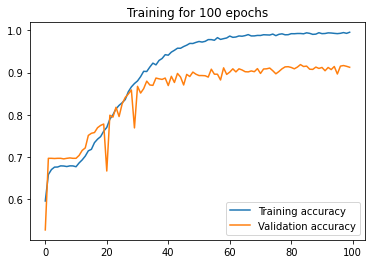

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

검증셋 정확도

In [18]:
model.load_weights(MODEL_PATH)
results = model.evaluate(x_val, y_val)
print('Test accuracy: ', results[1])

2196/2196 [==============================] - 1s 343us/step
Test accuracy:  0.9189435243606567


## 2.4 SVM 적용

마지막 레이어에서 특징추출

In [19]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(8784, 1000)
(2196, 1000)
(2746, 1000)


SVM에 적용

In [20]:
svm = SVC(kernel='rbf')

svm.fit(feat_train, np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


훈련셋 정확도

In [21]:
svm.score(feat_train, np.argmax(y_train,axis=1))

0.9986338797814208

검증셋 정확도

In [22]:
svm.score(feat_val, np.argmax(y_val,axis=1))

0.9193989071038251

SVM의 Prediction 저장

In [23]:
prediction = svm.predict(feat_test)

## 2.5 XGBoost 적용

In [24]:
xb = xgb.XGBClassifier()

xb.fit(feat_train, np.argmax(y_train,axis=1))
print('fitting done !!!')

fitting done !!!


검증셋 정확도

In [25]:
xb.score(feat_val, np.argmax(y_val,axis=1))

0.918943533697632

XGBoost의 Prediction 저장

In [26]:
prediction = xb.predict(feat_test)

최종 정확도 측정

In [27]:
xb.score(feat_test, np.argmax(y_test,axis=1))

0.9195193008011653